In [1]:
# coding: utf-8

# In[1]:

import numpy as np
#import h5py
#import tensorflow as tf
#import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
#from scipy import signal
from tensorflow.python.keras.layers import Input,Conv2D,Concatenate,Flatten,Dense,LeakyReLU,Dropout, ReLU
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.python.keras.models import Model


from tensorflow.python.keras import backend as K

from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.optimizers import Adam
# from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint

from sklearn.model_selection import train_test_split

#from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
#from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.python.keras.models import Sequential
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
fn = 2
d_min = 1
d_max = 10
blur_filter_size = 11
blur_range = 10
image_size = 512
epochs = 300
batch_size = 28

In [3]:
train_data_path = 'train_data_8000.npy'
test_data_path = 'real_data_2000.npy'
train_label_path = 'train_label_8000.npy'
test_label_path = 'real_label_2000.npy'

In [4]:
train_data = np.load(train_data_path)
test_data = np.load(test_data_path)
train_label = np.load(train_label_path)
test_label = np.load(test_label_path)

In [5]:
print(train_data.shape)
print(train_label.shape)


(8000, 512, 512, 1)
(8000, 2)


[1.    1.005]


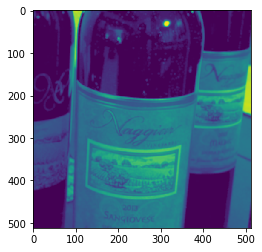

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
idx =5
plt.imshow(train_data[idx, :, :, 0])
print(train_label[idx, :])

[1.    1.014 0.   ]


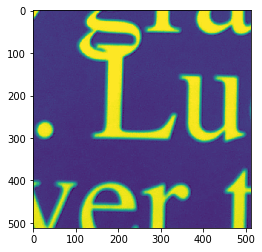

In [7]:
plt.imshow(test_data[idx, :, :, 0])
print(test_label[idx, :])

In [8]:
# In[7]:
input_image1 = Input(shape=(512,512,1), name = "input")
#layer1_1 = Conv2D(4, (8, 8), 8,padding='valid',activation=None,use_bias=False,kernel_initializer = my_init,trainable=True,name='layer1')(input_image1)
layer1_1 = Conv2D(4, (8, 8), 8,padding='valid',activation=relu, name="Conv1_1")(input_image1)
#layer1_1 = LeakyReLU(0.1)(layer1_1)

layer2_1 = Conv2D(8, (4, 4), 4,padding='valid',activation=relu, name="Conv2_1")(layer1_1)
#layer2_1 = LeakyReLU(0.1)(layer2_1)

layer3_1 = Conv2D(8, (4, 4), 4,padding='valid',activation=relu, name="Conv3_1")(layer2_1)
#layer3_1 = LeakyReLU(0.1)(layer3_1)


flattened = Flatten(name="flat")(layer3_1)
dense1 = Dense(1024, name="d1")(flattened)
ReLU1 = LeakyReLU(0.1, name="lr1")(dense1)
#dense1 = Dropout(0.8)(dense1)

dense2 = Dense(512, name="d2")(ReLU1)
ReLU2 = LeakyReLU(0.1, name="lr2")(dense2)
#dense2 = Dropout(0.5)(dense2)

dense3 = Dense(10, name="d3")(ReLU2)
ReLU3 = LeakyReLU(0.1, name="lr3")(dense3)

output_position = Dense(1, name="out")(ReLU3)
print(output_position)

model = Model(inputs=input_image1, outputs=output_position)
model.summary()

tcbc = TensorBoard(log_dir='1')

filepath="models/gen/n_{epoch:03d}-{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='max',period=2)

print(model.output_shape)

Tensor("out/BiasAdd:0", shape=(?, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512, 512, 1)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 64, 64, 4)         260       
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 16, 16, 8)         520       
_________________________________________________________________
Conv3_1 (Conv2D)             (None, 4, 4, 8)           1032      
_________________________________________________________________
flat (Flatten)               (None, 128)               0         
_________________________________________________________________
d1 (Dense)                   (None, 1024)              132096    
_________________________________________________________________
lr1 (LeakyReLU)        

In [9]:
def data_gen(features, labels, batch_size):
    while True:
        for i in np.arange(0, features.shape[0] - batch_size, batch_size):
            # choose random index in features
            batch_features = features[i:i+batch_size, :, :, :].astype('float16')/255.0
            batch_labels = abs(labels[i:i+batch_size, 1:2] - labels[i:i+batch_size, :1])*100
            yield (batch_features, batch_labels)

In [10]:
opt = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=None, decay=0.0001)
model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5))

X_train, X_test, y_train, y_test = train_test_split(
    train_data, train_label, test_size=0.05, random_state=2233)

# model.fit(train_data[:,:,:,0:1].astype('float16')/255.0, abs(train_label[:,1:2]-train_label[:,0:1])/100, 
#           epochs = 100,batch_size = batch_size, #validation_split=0.2,
#           validation_data=(test_data[:,:,:,0:1].astype('float16')/255.0, abs(test_label[:,1:2]-test_label[:,0:1])/100), 
#           verbose=1, callbacks = [tcbc, checkpoint])
model.fit_generator(data_gen(X_train, y_train, batch_size), 
                    steps_per_epoch = X_train.shape[0]/batch_size, epochs = epochs,
                    validation_data=data_gen(test_data, test_label, batch_size), 
                    validation_steps = batch_size,verbose=1, callbacks = [tcbc, checkpoint])

Epoch 1/300
272/271 [==============================] - 25s 94ms/step - loss: 5.0188 - val_loss: 6.5192
Epoch 2/300
271/271 [============================>.] - ETA: 0s - loss: 2.3784
Epoch 00002: saving model to models/gen/n_002-8.409.hdf5
272/271 [==============================] - 24s 89ms/step - loss: 2.3747 - val_loss: 8.4089
Epoch 3/300
272/271 [==============================] - 24s 88ms/step - loss: 2.0406 - val_loss: 7.5992
Epoch 4/300
271/271 [============================>.] - ETA: 0s - loss: 1.8979
Epoch 00004: saving model to models/gen/n_004-7.511.hdf5
272/271 [==============================] - 24s 88ms/step - loss: 1.8988 - val_loss: 7.5109
Epoch 5/300
272/271 [==============================] - 25s 91ms/step - loss: 1.8358 - val_loss: 6.3822
Epoch 6/300
271/271 [============================>.] - ETA: 0s - loss: 1.7173
Epoch 00006: saving model to models/gen/n_006-7.083.hdf5
272/271 [==============================] - 25s 92ms/step - loss: 1.7149 - val_loss: 7.0826
Epoch 7/300
2

Epoch 51/300
272/271 [==============================] - 24s 87ms/step - loss: 0.7837 - val_loss: 3.2532
Epoch 52/300
271/271 [============================>.] - ETA: 0s - loss: 0.7737
Epoch 00052: saving model to models/gen/n_052-3.017.hdf5
272/271 [==============================] - 24s 88ms/step - loss: 0.7735 - val_loss: 3.0171
Epoch 53/300
272/271 [==============================] - 24s 88ms/step - loss: 0.7622 - val_loss: 3.6904
Epoch 54/300
271/271 [============================>.] - ETA: 0s - loss: 0.7548
Epoch 00054: saving model to models/gen/n_054-3.622.hdf5
272/271 [==============================] - 24s 87ms/step - loss: 0.7545 - val_loss: 3.6220
Epoch 55/300
272/271 [==============================] - 24s 87ms/step - loss: 0.7462 - val_loss: 4.5684
Epoch 56/300
271/271 [============================>.] - ETA: 0s - loss: 0.7422
Epoch 00056: saving model to models/gen/n_056-3.438.hdf5
272/271 [==============================] - 24s 88ms/step - loss: 0.7440 - val_loss: 3.4380
Epoch 5

Epoch 101/300
272/271 [==============================] - 24s 88ms/step - loss: 0.3974 - val_loss: 3.2585
Epoch 102/300
271/271 [============================>.] - ETA: 0s - loss: 0.3884
Epoch 00102: saving model to models/gen/n_102-3.891.hdf5
272/271 [==============================] - 24s 88ms/step - loss: 0.3878 - val_loss: 3.8909
Epoch 103/300
272/271 [==============================] - 24s 87ms/step - loss: 0.3836 - val_loss: 3.2639
Epoch 104/300
271/271 [============================>.] - ETA: 0s - loss: 0.3719
Epoch 00104: saving model to models/gen/n_104-3.652.hdf5
272/271 [==============================] - 24s 88ms/step - loss: 0.3713 - val_loss: 3.6516
Epoch 105/300
272/271 [==============================] - 24s 88ms/step - loss: 0.3627 - val_loss: 2.8624
Epoch 106/300
271/271 [============================>.] - ETA: 0s - loss: 0.3568
Epoch 00106: saving model to models/gen/n_106-2.472.hdf5
272/271 [==============================] - 24s 87ms/step - loss: 0.3570 - val_loss: 2.4717
E

Epoch 151/300
272/271 [==============================] - 24s 88ms/step - loss: 0.1144 - val_loss: 3.5548
Epoch 152/300
271/271 [============================>.] - ETA: 0s - loss: 0.1320
Epoch 00152: saving model to models/gen/n_152-3.185.hdf5
272/271 [==============================] - 24s 88ms/step - loss: 0.1318 - val_loss: 3.1851
Epoch 153/300
272/271 [==============================] - 24s 87ms/step - loss: 0.1390 - val_loss: 3.6633
Epoch 154/300
271/271 [============================>.] - ETA: 0s - loss: 0.1428
Epoch 00154: saving model to models/gen/n_154-3.135.hdf5
272/271 [==============================] - 24s 88ms/step - loss: 0.1428 - val_loss: 3.1348
Epoch 155/300
272/271 [==============================] - 24s 87ms/step - loss: 0.1364 - val_loss: 2.6869
Epoch 156/300
271/271 [============================>.] - ETA: 0s - loss: 0.1342
Epoch 00156: saving model to models/gen/n_156-2.991.hdf5
272/271 [==============================] - 24s 88ms/step - loss: 0.1340 - val_loss: 2.9906
E

Epoch 201/300
272/271 [==============================] - 24s 87ms/step - loss: 0.0783 - val_loss: 3.5341
Epoch 202/300
271/271 [============================>.] - ETA: 0s - loss: 0.0839
Epoch 00202: saving model to models/gen/n_202-4.388.hdf5
272/271 [==============================] - 24s 87ms/step - loss: 0.0837 - val_loss: 4.3885
Epoch 203/300
272/271 [==============================] - 24s 87ms/step - loss: 0.0877 - val_loss: 4.1773
Epoch 204/300
271/271 [============================>.] - ETA: 0s - loss: 0.0921
Epoch 00204: saving model to models/gen/n_204-4.617.hdf5
272/271 [==============================] - 24s 87ms/step - loss: 0.0919 - val_loss: 4.6166
Epoch 205/300
272/271 [==============================] - 24s 87ms/step - loss: 0.1024 - val_loss: 4.8702
Epoch 206/300
271/271 [============================>.] - ETA: 0s - loss: 0.1013
Epoch 00206: saving model to models/gen/n_206-3.993.hdf5
272/271 [==============================] - 24s 87ms/step - loss: 0.1010 - val_loss: 3.9933
E

Epoch 251/300
272/271 [==============================] - 24s 87ms/step - loss: 0.0474 - val_loss: 3.6674
Epoch 252/300
271/271 [============================>.] - ETA: 0s - loss: 0.0524
Epoch 00252: saving model to models/gen/n_252-3.259.hdf5
272/271 [==============================] - 24s 87ms/step - loss: 0.0523 - val_loss: 3.2594
Epoch 253/300
272/271 [==============================] - 24s 87ms/step - loss: 0.0575 - val_loss: 3.5812
Epoch 254/300
271/271 [============================>.] - ETA: 0s - loss: 0.0615
Epoch 00254: saving model to models/gen/n_254-3.999.hdf5
272/271 [==============================] - 24s 88ms/step - loss: 0.0614 - val_loss: 3.9991
Epoch 255/300
272/271 [==============================] - 24s 88ms/step - loss: 0.0635 - val_loss: 3.8731
Epoch 256/300
271/271 [============================>.] - ETA: 0s - loss: 0.0624
Epoch 00256: saving model to models/gen/n_256-4.566.hdf5
272/271 [==============================] - 24s 88ms/step - loss: 0.0623 - val_loss: 4.5664
E

In [11]:
# model.save('my_model_512.h5')

In [12]:
# print(train_label[:, :10])

In [13]:
# from tensorflow.python.keras.models import load_model
# model = load_model('models/050-0.65.hdf5')

In [14]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# idxx = 89
# plt.imshow(test_data[idxx, :, :, 0])
# print(test_label[idxx, :])

In [15]:
# model.predict(test_data[idxx:idxx+1, :, :, :1]/255.0)

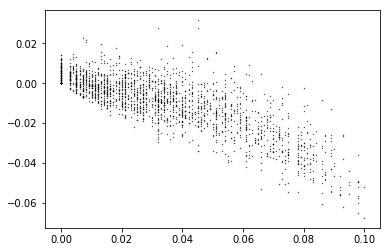

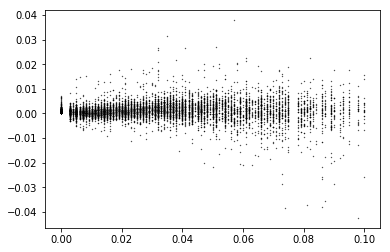

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(2000//64-1): #
    test_pred = model.predict(test_data[64*i:64*i+64, :, :, :1]/255.0)
    test_pred[test_pred<0]= 0
    plt.scatter(abs(test_label[64*i:64*i+64, 0] - test_label[64*i:64*i+64, 1]), test_pred[:, 0]/100 - abs(test_label[64*i:64*i+64, 0] - test_label[64*i:64*i+64, 1]), color='black', s = 0.1)
plt.show()
for i in range(8000//64-1): #
    train_pred = model.predict(train_data[64*i:64*i+64, :, :, :1]/255.0)
    train_pred[train_pred<0]= 0
    plt.scatter(abs(train_label[64*i:64*i+64, 0] - train_label[64*i:64*i+64, 1]), train_pred[:, 0]/100 - abs(train_label[64*i:64*i+64, 0] - train_label[64*i:64*i+64, 1]), color='black', s = 0.1)
plt.show()

In [17]:
# test_pred[test_pred<0]= 0
# print(test_pred[:, 0])

In [18]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.imshow(test_data[0, :, :, 0])
# print(test_label)

In [19]:
# plt.scatter(abs(test_label[:, 0] - test_label[:, 1]), test_pred[:, 0])